Set up environment

In [1]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
sns.set_style("white")

In [2]:
import sys
sys.path.append('/Users/zeynepenkavi/Dropbox/RangelLab/NeuralMassModels/helpers')
from eGLM_model import default_args, generateStructuralNetwork, generateSynapticNetwork, networkModel
from eGLM_helpers import phi, make_stimtimes
from multregconn import multregconn
from get_pearson_fc_wci import get_pearson_fc_wci
from get_multreg_fc_wci import get_multreg_fc_wci

Importing eGLM helpers...
All eGLM helpers imported!


# Make network

In [3]:
num_sims = 10
networks = np.ndarray(num_sims, dtype=object)

In [4]:
for i in range(num_sims):
    sim_args = copy(default_args)
    sim_args.update({'hubnetwork_dsity': .5,
                'outnetwork_dsity':.3, 
                'innetwork_dsity': .60,})
    W = generateSynapticNetwork(generateStructuralNetwork(sim_args))
    sim_args.update({'W': W,
                'noise': 1, 
                'noise_scale': 1,
                'Tmax': 1500})
    networks[i] = sim_args

# Generate time series

## Resting

Resting data in this case is only noise not an AR(1) process.

In [5]:
rest_data = np.ndarray(num_sims, dtype=object)

for i in range(num_sims):
    sim_args = networks[i]
    rest_data[i], _ = networkModel(sim_args['W'], args_dict=sim_args)

# Compute FC connectivity matrices

## Pearson


In [6]:
pearson_fcs = np.ndarray(num_sims, dtype=object)
pearson_fcs_lb = np.ndarray(num_sims, dtype=object)
pearson_fcs_ub = np.ndarray(num_sims, dtype=object)
pearson_fcs_rmse = np.ndarray(num_sims, dtype=object)

for i, cur_data in enumerate(rest_data):
    pearson_fcs[i], pearson_fcs_lb[i], pearson_fcs_ub[i], pearson_fcs_rmse[i] = get_pearson_fc_wci(cur_data, networks[i])

Plot distribution of rmse's

Text(0.5, 0, 'RMSE')

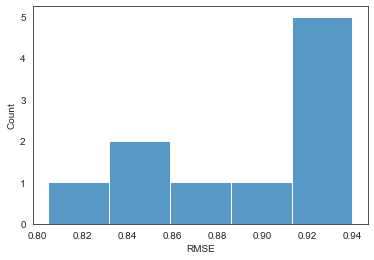

In [7]:
sns.histplot(pearson_fcs_rmse)
plt.xlabel("RMSE")

Plot predicted vs actual with CI's around predicted values for each (x=y line added in blue)

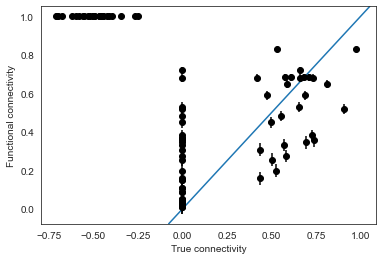

In [8]:
for i in range(num_sims):
    le = pearson_fcs[i] - pearson_fcs_lb[i]
    ue = pearson_fcs_ub[i] - pearson_fcs[i]
    plt.errorbar(x = np.ndarray.flatten(networks[i]['W']), y = np.ndarray.flatten(pearson_fcs[i]), yerr = np.array([np.ndarray.flatten(le), np.ndarray.flatten(ue)]), fmt='o', color="black")

plt.xlabel("True connectivity")
plt.ylabel("Functional connectivity")
plt.axline([0, 0], [1, 1])

## Multiple regression

FC estimated by using the [multiple regression used by Cole et al.](https://github.com/ColeLab/ActflowToolbox/blob/master/connectivity_estimation/multregconn.py) expanded to add confidence intervals and rmse [here](https://github.com/zenkavi/NeuralMassModels/blob/master/helpers/multregconn.py).

In [9]:
mreg_fcs = np.ndarray(num_sims, dtype=object)
mreg_fcs_lb = np.ndarray(num_sims, dtype=object)
mreg_fcs_ub = np.ndarray(num_sims, dtype=object)
mreg_fcs_rmse = np.ndarray(num_sims, dtype=object)

for i, cur_data in enumerate(rest_data):
    mreg_fcs[i], mreg_fcs_lb[i], mreg_fcs_ub[i], mreg_fcs_rmse[i] = get_multreg_fc_wci(cur_data, networks[i])

Text(0.5, 0, 'RMSE')

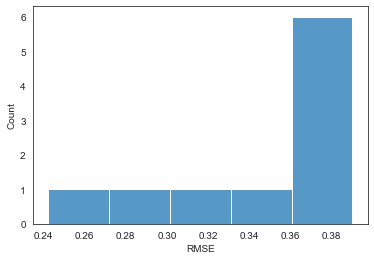

In [11]:
sns.histplot(mreg_fcs_rmse)
plt.xlabel("RMSE")

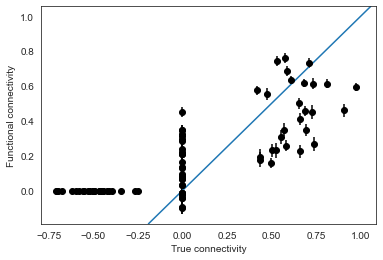

In [13]:
for i in range(num_sims):
    le = mreg_fcs[i] - mreg_fcs_lb[i]
    ue = mreg_fcs_ub[i] - mreg_fcs[i]
    plt.errorbar(x = np.ndarray.flatten(networks[i]['W']), y = np.ndarray.flatten(mreg_fcs[i]), yerr = np.array([np.ndarray.flatten(le), np.ndarray.flatten(ue)]), fmt='o', color="black")

plt.xlabel("True connectivity")
plt.ylabel("Functional connectivity")
plt.axline([0, 0], [1, 1])

TODO: Add lag option to connectivity computations